# Continuous Optimization: Nonlinear Programming

In [1]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

In [2]:
import pandas as pd
import pyomo.environ as pyo

## Nonlinear Programs: Circle Packing Example

What is the smallest rectangle you can use to enclose three given circles? Reference: Example 4.4 in Biegler (2010).

![picture](https://raw.githubusercontent.com/ndcbe/optimization/main/media/pack1.png)

### Propose an Optimization Model

The following optimization model is given in Biegler (2010):

$$
\begin{align}
\text{min} \quad & 2(A + B) \\
\text{s.t.} \quad & A \geq 0, \quad B \geq 0, \\
& x_1, y_1, \geq R_1, \quad x_1 \leq B - R_1, \quad y_1 \leq A - R_1, \\
& x_2, y_2, \geq R_2, \quad x_2 \leq B - R_2, \quad y_2 \leq A - R_2, \\
& x_3, y_3, \geq R_3, \quad x_3 \leq B - R_3, \quad y_3 \leq A - R_3, \\
& (x_1 - x_2)^2 + (y_1 - y_2)^2 \geq (R_1 + R_2)^2, \\
& (x_1 - x_3)^2 + (y_1 - y_3)^2 \geq (R_1 + R_3)^2, \\
& (x_2 - x_3)^2 + (y_2 - y_3)^2 \geq (R_2 + R_3)^2,
\end{align}
$$

How can we more compactly represent this using sets?

<div class="admonition note"> 
<p class="title"><b>Activity</b></p>
 Identify the sets, parameters, variables, and constraints.
</div>

**Sets**

**Parameters**

**Variables**

**Constraints**

**Complete Optimization Formulation**

```{dropdown} Click to see the solution to the activity
$$
\begin{align}
\text{min} \quad & 2(A + B) \\
\text{s.t.} \quad & A \geq 0, \quad B \geq 0, \\
& x_i, y_i, \geq R_i, \quad x_i \leq B - R_i, \quad y_i \leq A - R_i, \forall i \in \mathcal{C} \\
& (x_i - x_j)^2 + (y_i - y_j)^2 \geq (R_i + R_j)^2, \forall i,j \in \{i \in \mathcal{C}, j \in \mathcal{C}: i < j\}
\end{align}
$$


<div class="admonition note"> 
<p class="title"><b>Activity</b></p>
 Perform degree of freedom analysis.
</div>

**Degree of Freedom Analysis**

### Implement in Pyomo

First, we will define functions to create and intialize the model.

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def create_circle_model(circle_radii):
    ''' Create circle optimization model in Pyomo
    
    Arguments:
        circle_radii: dictionary with keys=circle name and value=radius (float)
        
    Returns:
        model: Pyomo model
    '''

    # Number of circles to consider
    n = len(circle_radii)

    # Create a concrete Pyomo model.
    model = pyo.ConcreteModel()

    # Initialize index for circles
    model.CIRCLES = pyo.Set(initialize = circle_radii.keys())
    
    # Create parameter
    model.R = pyo.Param(model.CIRCLES, domain=pyo.PositiveReals, initialize=circle_radii)

    # Create variables for box
    model.a = pyo.Var(domain=pyo.PositiveReals)
    model.b = pyo.Var(domain=pyo.PositiveReals)

    # Set objective
    model.obj = pyo.Objective(expr=2*(model.a + model.b), sense = pyo.minimize)

    # Create variables for circle centers
    model.x = pyo.Var(model.CIRCLES, domain=pyo.PositiveReals)
    model.y = pyo.Var(model.CIRCLES, domain=pyo.PositiveReals)

    # "In the box" constraints
    def left_x(m,c):
        return m.x[c] >= model.R[c]
    model.left_x_con = pyo.Constraint(model.CIRCLES, rule=left_x)

    def left_y(m,c):
        return m.y[c] >= model.R[c]
    model.left_y_con = pyo.Constraint(model.CIRCLES, rule=left_y)

    def right_x(m,c):
        return m.x[c] <= m.b - model.R[c]
    model.right_x_con = pyo.Constraint(model.CIRCLES, rule=right_x)

    def right_y(m,c):
        return m.y[c] <= m.a - model.R[c]
    model.right_y_con = pyo.Constraint(model.CIRCLES, rule=right_y)

    # No overlap constraints
    def no_overlap(m,c1,c2):
        if c1 < c2:
            return (m.x[c1] - m.x[c2])**2 + (m.y[c1] - m.y[c2])**2 >= (model.R[c1] + model.R[c2])**2
        else:
            return pyo.Constraint.Skip
    model.no_overlap_con = pyo.Constraint(model.CIRCLES, model.CIRCLES, rule=no_overlap)
    
    return model

def initialize_circle_model(model, a_init=25, b_init=25):
    ''' Initialize the x and y coordinates using uniform distribution
    
    Arguments:
        a_init: initial value for a (default=25)
        b_init: initial value for b (default=25)
        
    Returns:
        Nothing. But per Pyomo scoping rules, the input argument `model`
        can be modified in this function.
    
    '''
    # Initialize 
    model.a = 25
    model.b = 25

    for i in model.CIRCLES:
        # Adding circle radii ensures the remains in the >0, >0 quadrant
        model.x[i] = random.uniform(0,10) + model.R[i]
        model.y[i] = random.uniform(0,10) + model.R[i]



Next, we will create a dictionary containing the circle names and radii values.

In [14]:
# Create dictionary with circle data
circle_data = {'A':10.0, 'B':5.0, 'C':3.0}
circle_data

{'A': 10.0, 'B': 5.0, 'C': 3.0}

In [15]:
# Access the keys
circle_data.keys()

dict_keys(['A', 'B', 'C'])

Now let's create the model.

In [16]:
# Create model
model = create_circle_model(circle_data)
model.pprint()

1 Set Declarations
    CIRCLES : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}

1 Param Declarations
    R : Size=3, Index=CIRCLES, Domain=PositiveReals, Default=None, Mutable=False
        Key : Value
          A :  10.0
          B :   5.0
          C :   3.0

4 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : PositiveReals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : PositiveReals
    x : Size=3, Index=CIRCLES
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          A :     0 :  None :  None : False :  True : PositiveReals
          B :     0 :  None :  None : False :  True : PositiveReals
          C :     0 :  None :  None : False :  True : PositiveReals
    y : Size=

And let's initialize the model.

In [17]:
# Initialize model
initialize_circle_model(model)
model.pprint()

1 Set Declarations
    CIRCLES : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}

1 Param Declarations
    R : Size=3, Index=CIRCLES, Domain=PositiveReals, Default=None, Mutable=False
        Key : Value
          A :  10.0
          B :   5.0
          C :   3.0

4 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    25 :  None : False : False : PositiveReals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    25 :  None : False : False : PositiveReals
    x : Size=3, Index=CIRCLES
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          A :     0 : 19.721128404129697 :  None : False : False : PositiveReals
          B :     0 :   7.08632115423932 :  None : False : False : PositiveReals
          C :     0 :   4.18185123759586 :

<div class="admonition note"> 
    <p class="title"><b>Activity</b></p>
 Compare the initial values for <tt>x</tt> and <tt>y</tt> with and without initialization. What is the default initial value in Pyomo?
</div>

### Visualize Initial Point

Next, we'll define a function to plot the solution (or initial point)

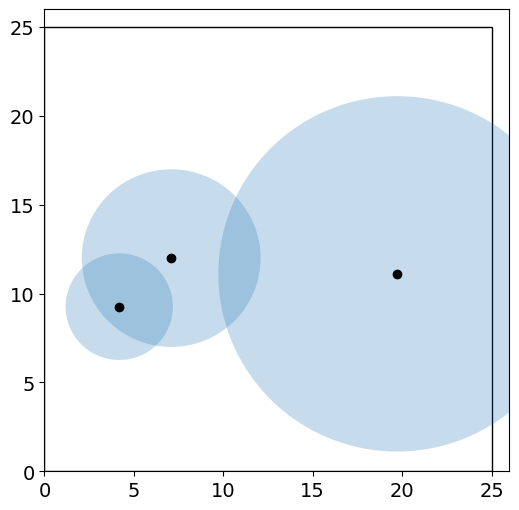

In [18]:
# Plot initial point

def plot_circles(m):
    ''' Plot circles using data in Pyomo model
    
    Arguments:
        m: Pyomo concrete model
    
    Returns:
        Nothing (but makes a figure)
    
    '''
    
    # Create figure
    fig, ax = plt.subplots(1,figsize=(6,6))
    
    # Adjust axes
    l = max(m.a.value,m.b.value) + 1
    ax.set_xlim(0,l)
    ax.set_ylim(0,l)
    
    # Draw box
    art = mpatches.Rectangle((0,0), width=m.b.value, height=m.a.value,fill=False)
    ax.add_patch(art)

    # Draw circles and mark center
    for i in m.CIRCLES:
        art2 = mpatches.Circle( (m.x[i].value,m.y[i].value), radius=m.R[i],fill=True,alpha=0.25)
        ax.add_patch(art2)
        
        plt.scatter(m.x[i].value,m.y[i].value,color='black')
    
    # Show plot
    plt.show()
    
plot_circles(model)

### Solve and Inspect the Solution

In [19]:
# Specify the solver
solver = pyo.SolverFactory('ipopt')

# Solve the model
results = solver.solve(model, tee = True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Next, we can inspect the solution. Because Pyomo is a Python extension, we can use Pyoth (for loops, etc.) to programmatically inspect the solution.

Name	Value
a 	 19.999999803189517
b 	 29.142135416184733
x[A] 	 19.142135514931894
x[B] 	 4.999999951252102
x[C] 	 5.388458700112411
y[A] 	 9.999999901252012
y[B] 	 14.999999849644189
y[C] 	 4.720856828961742


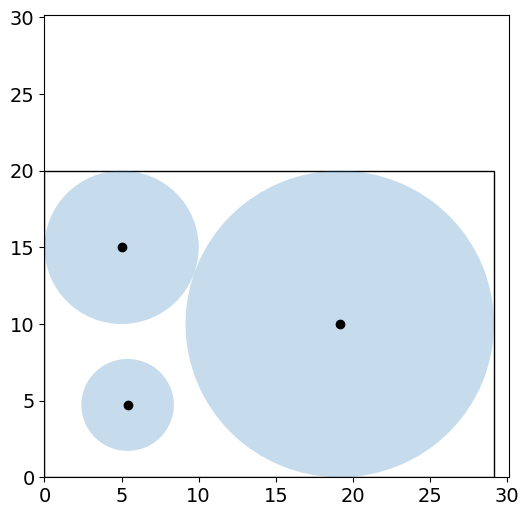

In [20]:
# Print variable values
print("Name\tValue")
for c in model.component_data_objects(pyo.Var):
    print(c.name,"\t", pyo.value(c))

# Plot solution
plot_circles(model)

In [21]:
# Print constraints
for c in model.component_data_objects(pyo.Constraint):
    print(c.name,"\t", pyo.value(c.lower),"\t", pyo.value(c.body),"\t", pyo.value(c.upper))

left_x_con[A] 	 10.0 	 19.142135514931894 	 None
left_x_con[B] 	 5.0 	 4.999999951252102 	 None
left_x_con[C] 	 3.0 	 5.388458700112411 	 None
left_y_con[A] 	 10.0 	 9.999999901252012 	 None
left_y_con[B] 	 5.0 	 14.999999849644189 	 None
left_y_con[C] 	 3.0 	 4.720856828961742 	 None
right_x_con[A] 	 None 	 9.87471615587765e-08 	 0.0
right_x_con[B] 	 None 	 -19.14213546493263 	 0.0
right_x_con[C] 	 None 	 -20.75367671607232 	 0.0
right_y_con[A] 	 None 	 9.806249501309594e-08 	 0.0
right_y_con[B] 	 None 	 4.645467122088576e-08 	 0.0
right_y_con[C] 	 None 	 -12.279142974227774 	 0.0
no_overlap_con[A,B] 	 225.0 	 224.99999778541851 	 None
no_overlap_con[A,C] 	 169.0 	 217.03297750421336 	 None
no_overlap_con[B,C] 	 64.0 	 105.81168143921077 	 None


### Reinitialize and Resolve

<div class="admonition note"> 
    <p class="title"><b>Activity</b></p>
 Reinitialize the model, plot the initial point, resolve, and plot the solution. Is there more than one solution?
</div>

In [22]:
# Initialize and print the model

# Add your solution here

1 Set Declarations
    CIRCLES : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}

1 Param Declarations
    R : Size=3, Index=CIRCLES, Domain=PositiveReals, Default=None, Mutable=False
        Key : Value
          A :  10.0
          B :   5.0
          C :   3.0

4 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    25 :  None : False : False : PositiveReals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    25 :  None : False : False : PositiveReals
    x : Size=3, Index=CIRCLES
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          A :     0 : 10.850147023982599 :  None : False : False : PositiveReals
          B :     0 :  9.780923462544251 :  None : False : False : PositiveReals
          C :     0 :  10.61608289663573 :

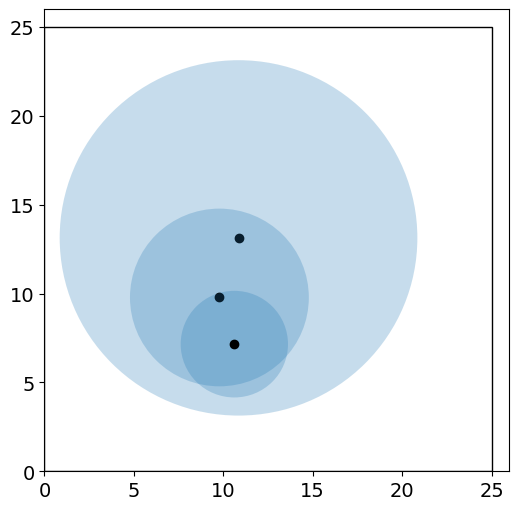

In [23]:
# Plot initial point
# Add your solution here

In [24]:
# Solve the model
# Add your solution here

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

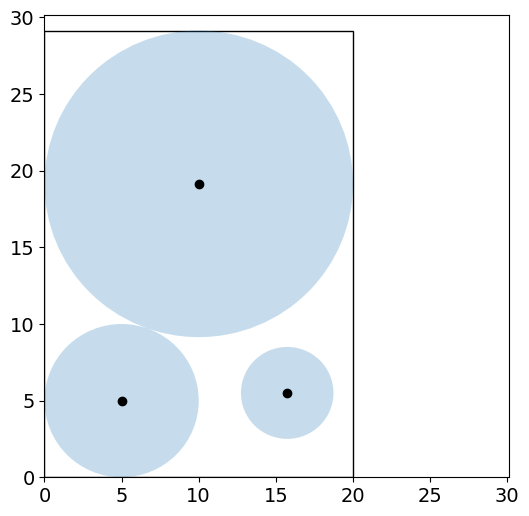

In [25]:
# Plot solution
# Add your solution here

## Take Away Messages
* Linear programs are convex. We will learn this means all local optima are global optima.
* Nonlinear programs may be nonconvex. For nonconvex problems, there often existings many local optima that are not also global optima.
* We will learn how to mathematically define convexity and analyze this property.
* Initialization is really important in optimization problems with nonlinear objectives or constraints!
* There are specialize solves for linear programs, quadratic programs, and convex programs. In this class, we will focus on more general algorithms for (non)convex nonlinear programs including the algorithms used by the `ipopt` solver.